In [1]:

import multiprocessing
print(multiprocessing.cpu_count())

import psutil
print(f"Available memory before training: {psutil.virtual_memory().available / 1e9:.2f} GB")

12
Available memory before training: 9.22 GB


In [2]:

import numpy as np
import pandas as pd
pd.set_option('display.max_info_columns', 200) #caps at 200, use None to show all
pd.set_option('display.max_rows', 200)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score as accuracy_score_sklearn
import xgboost 
from sklearn.model_selection import cross_val_score

In [3]:

token = 'p24'
study = pd.read_pickle("p004_diabetes_MLprep.pkl")

for col in study.select_dtypes(include='int64'):
    study[col] = study[col].astype('int32')
    
print(study.shape)

(78743, 176)


In [4]:

X = study.drop(['readmitted_ind'], axis=1)
y = study['readmitted_ind']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# leave these features in the data, but do not use them for modeling
exclude_features = ['patient_nbr', 'encounter_id', 'diagnosis_tuple', 'readmitted', 'dummy'] 
numeric_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'int32']
object_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])


In [5]:

def evaluate_and_save_pipeline(pipeline, namestring, token, 
                               X_train, X_test, 
                               y_train, y_test):
    """
    Evaluates a trained pipeline and saves metrics to a pickle file.
    """

    # Properly check for missing inputs
    if any(v is None for v in [X_train, X_test, y_train, y_test]):
        raise ValueError("X_train, X_test, y_train, or y_test must not be None.")

    # Ensure data is in expected format (convert to numpy if necessary)
    y_train = y_train.values if hasattr(y_train, "values") else y_train
    y_test = y_test.values if hasattr(y_test, "values") else y_test

    # Make predictions
    y_test_pred  = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)
    
    # Determine if model supports predict_proba or decision_function
    if hasattr(pipeline, "predict_proba"):
        print('pipeline.predict_proba(X_test)[:, 1] used for y_test_pred_pct')
        y_test_pred_pct = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        print('pipeline.decision_function(X_test) used for y_test_pred_pct')
        y_test_pred_pct = pipeline.decision_function(X_test)
    else:
        raise AttributeError("🚨 This pipeline has neither predict_proba() nor decision_function(). Cannot generate continuous scores for ROC/AUC.")
    

    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = pipeline.score(X_test, y_test)

    # Confusion matrix & sensitivity/specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_pct)
    roc_auc = auc(fpr, tpr)

    accuracy= (tp+tn)/ (tp+tn+fp+fn)
    accuracy_score= accuracy_score_sklearn(y_test, y_test_pred)

    # Save metrics
    fits_pickle = {
        'model_version': f"{token}_{namestring}",
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'y_test': y_test,
        
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
        'y_test_pred_pct': y_test_pred_pct,
        'display_labels': pipeline.classes_ ,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'accuracy': accuracy,
        'accuracy_score': accuracy_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc
    }

    with open(f"fits_pickle_{token}_{namestring}.pkl", "wb") as file:
        pickle.dump(fits_pickle, file)
    print(f"Fits data saved as fits_pickle_{token}_{namestring}.pkl")

    # Print summary
    print(f"Metrics saved to {filename}")
    print('MSE (Train):',  round(mse_train,4))
    print('MSE (Test):',   round(mse_test, 4))
    print('R-sq (Train):', round(r2_train, 4))
    print('R-sq (Test):',  round(r2_test,  4))
    print('Accuracy:',     round(accuracy,4))
    print('accuracy_score:',     round(accuracy_score,4))
    print('Sensitivity:',  round(sensitivity, 4))
    print('Specificity:',  round(specificity,  4))

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Test Data Confusion Matrix for {namestring} fit")
    plt.show()

    return fits_pickle

In [6]:

%%time
#optimize parameters for XGBoost
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of boosting rounds
    'learning_rate': np.logspace(-3, 0, 10),  # Learning rate (log scale)
    'max_depth': [3, 5, 7, 10],  # Tree depth
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of instance weight (regularization)
    'gamma': np.linspace(0, 0.5, 5),  # Minimum loss reduction
    'subsample': np.linspace(0.5, 1, 5),  # Fraction of samples per tree
    'colsample_bytree': np.linspace(0.5, 1, 5),  # Fraction of features per tree
    'reg_lambda': np.logspace(-3, 3, 10),  # L2 regularization (Ridge)
    'reg_alpha': np.logspace(-3, 3, 10)  # L1 regularization (Lasso)
}

xgb = xgboost.XGBClassifier(eval_metric='logloss', random_state=42)

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # Number of different random combinations to try
    scoring='accuracy',  # Use 'roc_auc' for imbalanced data
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=43,
    n_jobs=-1  # Use all available processors
)

xgb_tune = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', random_search_xgb )  
])

# Fit on training data
xgb_tune.fit(X_train, y_train)  

filename=f"{token}_xgb_tune.pkl"
with open(filename, "wb") as file:
    pickle.dump(xgb_tune, file)
print(f"Model saved as {filename}")

# Extract the best hyperparameters
best_params = xgb_tune['model'].best_params_
print("🔥 Best Hyperparameters for XGB:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model saved as p24_xgb_tune.pkl
🔥 Best Hyperparameters for XGB: {'subsample': 1.0, 'reg_lambda': 10.0, 'reg_alpha': 0.004641588833612777, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.75}
CPU times: total: 37.2 s
Wall time: 8min 6s


Model saved as p24_XGB.pkl
pipeline.predict_proba(X_test)[:, 1] used for y_test_pred_pct
Fits data saved as fits_pickle_p24_XGB.pkl
Metrics saved to p24_XGB.pkl
MSE (Train): 0.0252
MSE (Test): 0.0324
R-sq (Train): 0.9748
R-sq (Test): 0.9676
Accuracy: 0.9676
accuracy_score: 0.9676
Sensitivity: 0.9712
Specificity: 0.9644


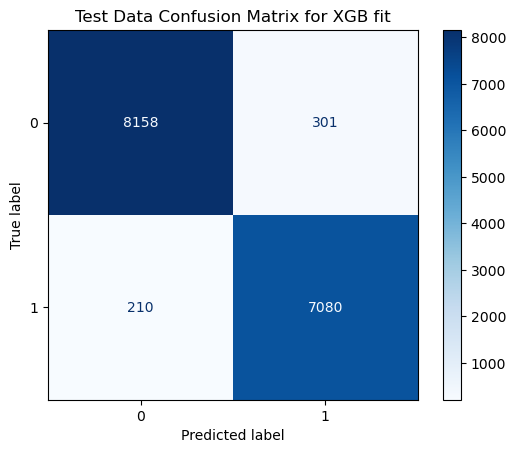

CPU times: total: 41.5 s
Wall time: 9.62 s


{'model_version': 'p24_XGB',
 'mse_train': 0.02522462456741912,
 'mse_test': 0.03244650453997079,
 'r2_train': 0.9747753754325809,
 'r2_test': 0.9675534954600292,
 'y_test': array([0, 0, 1, ..., 1, 0, 1]),
 'y_test_pred': array([0, 0, 1, ..., 1, 0, 1]),
 'y_train_pred': array([0, 1, 1, ..., 0, 0, 0]),
 'y_test_pred_pct': array([1.2884619e-04, 1.4417310e-04, 9.4323897e-01, ..., 9.9987149e-01,
        3.9325932e-05, 6.5321022e-01], dtype=float32),
 'display_labels': array([0, 1]),
 'tn': 8158,
 'fp': 301,
 'fn': 210,
 'tp': 7080,
 'accuracy': 0.9675534954600292,
 'accuracy_score': 0.9675534954600292,
 'sensitivity': 0.9711934156378601,
 'specificity': 0.9644165977065847,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.76864878, 0.76888521,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.37174211e-04, 4.11522634e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'thresholds': array([          inf, 9.9999547e-01, 9.9999356e-01, ..., 5.7917197e-05,
       

In [20]:

%%time
XGB = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', xgboost.XGBClassifier(**best_params, eval_metric='logloss', random_state=43))  
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 

XGB.fit(X_train, y_train)

filename=f"{token}_XGB.pkl"
with open(filename, "wb") as file:
    pickle.dump(XGB, file)
print(f"Model saved as {filename}")

evaluate_and_save_pipeline(
    pipeline=XGB, 
    namestring='XGB',
    token=token, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

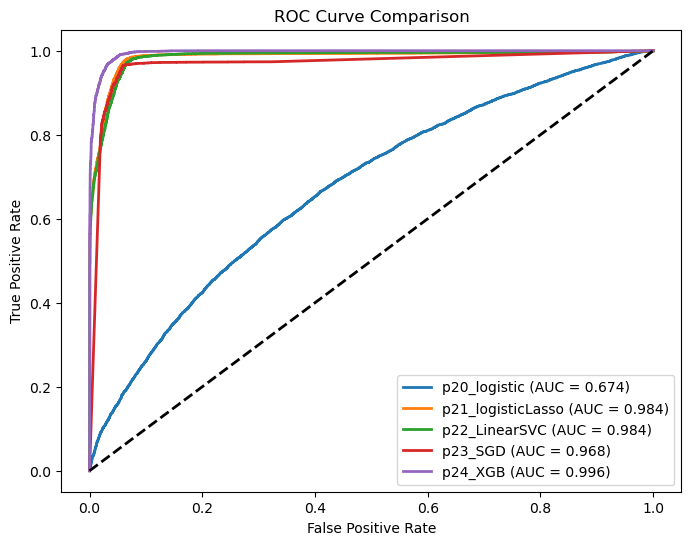

In [8]:

fits_pickles =['fits_pickle_p20_logistic.pkl'
             , 'fits_pickle_p21_logisticLasso.pkl'
             , 'fits_pickle_p22_LinearSVC.pkl'
             , 'fits_pickle_p23_SGD.pkl'
             , 'fits_pickle_p24_XGB.pkl' ]

colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # lime
    '#17becf',  # cyan
    '#393b79',  # dark blue
    '#637939'   # dark green
]

def plot_roc_curves(fits_pickles):
    plt.figure(figsize=(8, 6))
    
    for i, file in enumerate(fits_pickles):
        model_data = pd.read_pickle(file)
        plt.plot(model_data['fpr'], model_data['tpr'], color=colors[i % len(colors)], lw=2, 
                 label=f"{model_data['model_version']} (AUC = {model_data['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# plot_roc_curves(['lasso_metrics.pkl', 'ridge_metrics.pkl'])
plot_roc_curves(fits_pickles)

In [22]:

#Use the predicted probabilities to fit the 3-class target variable in the next program
X_with_proba = X.copy()
X_with_proba['predict_proba'] = XGB.predict_proba(X)[:, 1]

filename=f"{token}_X_with_proba.pkl"
with open(filename, "wb") as file:
    pickle.dump(X_with_proba, file)
print(f"X_with_proba saved as {filename}")

X_with_proba saved as p24_X_with_proba.pkl


In [1]:

#import pandas as pd
#XGB= pd.read_pickle('p24_XGB.pkl')
#token='p24'

# Step 1: Get the trained XGBoost model from your pipeline
model = XGB.named_steps['model'].best_estimator_ if hasattr(XGB.named_steps['model'], 'best_estimator_') else XGB.named_steps['model']

# Step 2: Get the preprocessor
preprocessor = XGB.named_steps['preprocessor']

# Step 3: Get feature names from numeric and categorical transformers
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][2]

# Get encoded feature names from OneHotEncoder
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = numeric_features + list(cat_feature_names)

# Step 4: Get feature importances
importances = model.feature_importances_

# Step 5: Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 6: Save to CSV for Excel
importance_df.to_csv(f"{token}_XGB_feature_importance.csv", index=False)

# Optional: Preview the top features
print(importance_df.head(10))


                    Feature  Importance
143   mb_readmitted_gt30_ct    0.537386
142   mb_readmitted_lt30_ct    0.152589
144     mb_readmitted_no_ct    0.096746
14      distinct_diag_count    0.038344
140            encounter_ct    0.035918
6          number_inpatient    0.022741
150  mb_number_inpatient_ct    0.016561
151  mb_number_diagnoses_ct    0.005525
189     admission_type_NULL    0.002537
164           A1Cresult_nan    0.002289
